In [59]:
%load_ext autoreload
%autoreload 2

import os
import sys
from glob import glob

import numpy as np
import pandas as pd
idx = pd.IndexSlice
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import copy

import geopandas as gpd

from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

import gpflow
import tensorflow as tf
import sys
code_dir = '/cluster/home/kheuto01/code/zero-inflated-gp/'
sys.path.append(code_dir)
from math import radians, cos, sin, asin, sqrt
from onoffgpf import OnOffSVGP, OnOffLikelihood

import pickle

from math import radians, cos, sin, asin, sqrt

import copy
import sys

import geopandas as gpd
import numpy as np

import gpflow


code_dir = '/cluster/home/kheuto01/code/zero-inflated-gp/'
sys.path.append(code_dir)

code_dir = '/cluster/home/kheuto01/code/opioid-overdose-models/'
sys.path.append(code_dir)

from onoffgpf import OnOffSVGP, OnOffSVGPPoiMC, OnOffLikelihood
gpflow.config.default_float()


from zinf_gp.metrics import normcdf, fixed_top_X

import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import contextily as ctx 
import geopandas as gpd 
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable


import matplotlib
matplotlib.style.use('default')
font = {
        'size'   : 22}

matplotlib.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

data_dir='/cluster/tufts/hugheslab/datasets/NSF_OD/results_20220606_update/'

log_dir='/cluster/tufts/hugheslab/kheuto01/opioid/logs/fix_two/'

run_template = '{time}_{loc}_{model}_{start_year}_{cov}_{num_inducing}_{lr}'

In [40]:
time = 'annual'
loc = 'tract'
model = 'normal'
start_year = 2000
cov = '-auto'
num_inducing = '400'
lr = 0.05

In [41]:
test_years = 2
geography_col='geoid'
timestep_col='timestep'
outcome_col='deaths'

# test y always comes from quarterly tract
y_timesteps_per_year = 4
file_name = f'clean_quarter_tract'
data_path = os.path.join(data_dir, file_name)

x_idx_cols = [geography_col, 'lat','lon', timestep_col,
      'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc',
      'svi_pctile',
      'neighbor_t', 'self_t-1']
y_idx_cols = [geography_col, timestep_col, outcome_col]
features_only = ['lat','lon', timestep_col,
                 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc',
                 'svi_pctile',
                 'neighbor_t', 'self_t-1']

data_gdf = gpd.read_file(data_path)

last_train_year = 2018
train_x_qtr = data_gdf[(data_gdf['year'] <= last_train_year)][x_idx_cols]

train_y_qtr = data_gdf[(data_gdf['year'] <= last_train_year)][y_idx_cols]

all_y_qtr = data_gdf[y_idx_cols]
test_x_qtr = data_gdf[(data_gdf['year'] > last_train_year) &
                  (data_gdf['year'] <= last_train_year+test_years)][x_idx_cols]

test_y = data_gdf[(data_gdf['year'] > last_train_year) &
                  (data_gdf['year'] <= last_train_year+test_years)][y_idx_cols]
starting_y_timestep = int(test_y[timestep_col].min())

sorted_y_timesteps = test_y[timestep_col].unique()
sorted_y_timesteps.sort()

x_timesteps_per_year = {'quarter':4, 'semi':2,'annual':1}[time]

file_name = f'clean_{time}_{loc}'
data_path = os.path.join(data_dir, file_name)

data_gdf = gpd.read_file(data_path)

train_x = data_gdf[(data_gdf['year'] <= last_train_year) &
                   (data_gdf['year'] >= start_year)][x_idx_cols]
train_y = data_gdf[(data_gdf['year'] <= last_train_year) &
                   (data_gdf['year'] >= start_year)][y_idx_cols]

test_x = data_gdf[(data_gdf['year'] > last_train_year) &
                  (data_gdf['year'] <= last_train_year+test_years)][x_idx_cols]

starting_x_timestep = int(test_x[timestep_col].min())

test_timesteps_per_year = max(y_timesteps_per_year, x_timesteps_per_year)
test_timesteps = test_timesteps_per_year*test_years

x_repeats = int(test_timesteps_per_year/x_timesteps_per_year)
y_repeats = int(test_timesteps_per_year/y_timesteps_per_year)

sorted_x_timesteps = test_x[timestep_col].unique()
sorted_x_timesteps.sort()

x_timesteps = [timestep  for timestep in sorted_x_timesteps for _ in range(x_repeats)]

y_timesteps = [timestep  for timestep in sorted_y_timesteps for _ in range(y_repeats)]



In [42]:
this_run = run_template.format(time=time,loc=loc,model=model,start_year=start_year,
                                                           cov=cov,
                                                           num_inducing=num_inducing,lr=lr)
with open(os.path.join(log_dir,this_run,'model.mod'),'rb') as f:
        predictor = pickle.load(f)
with open(os.path.join(log_dir,this_run,'stats.csv'),'rb') as f:
    stats = pd.read_csv(f)

In [78]:
new_tract_shapefile = os.path.join(os.path.dirname(os.path.dirname(data_dir)),'shapefiles','new_trimmed_tract',
                                   'cb_2020_tract')
town_shapefile = os.path.join(os.path.dirname(os.path.dirname(data_dir)),'shapefiles','MA_2020_Towns',
                              'CENSUS2020TOWNS_POLY.shp')
mass_gdf = gpd.read_file(new_tract_shapefile)
town_gdf = gpd.read_file(town_shapefile)


In [79]:
year = 0
for x_time,y_time in zip(x_timesteps[year*x_timesteps_per_year:(year+1)*x_timesteps_per_year],
                                                         y_timesteps[year*y_timesteps_per_year:(year+1)*y_timesteps_per_year]):

        test_x_time = test_x[test_x[timestep_col] == x_time]
        test_y_time = test_y[test_y[timestep_col] == y_time]
        _, _, _, fmean, fvar, gmean, gvar, _, _ = predictor.build_predict(test_x_time.loc[:, features_only].values)
        g_cond = tf.math.softplus(fmean * normcdf(gmean)).numpy()
        pred_df = pd.Series(g_cond.squeeze(), index=test_x_time[geography_col])
        break

In [98]:
test_series = test_y_time.set_index('geoid')
residuals = (test_series['deaths']-pred_df/4)

In [46]:
pred_df.max()

3.8826427694159507

In [39]:
pred_df.min()

1.482969264661678e-83

In [100]:
residual_gdf = mass_gdf.merge(residuals.rename('residuals'), right_index=True, left_on='GEOID')

In [101]:
residual_gdf.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'AFFGEOID', 'GEOID', 'NAME',
       'NAMELSAD', 'STUSPS', 'NAMELSADCO', 'STATE_NAME', 'LSAD', 'ALAND',
       'AWATER', 'geometry', 'residuals'],
      dtype='object')

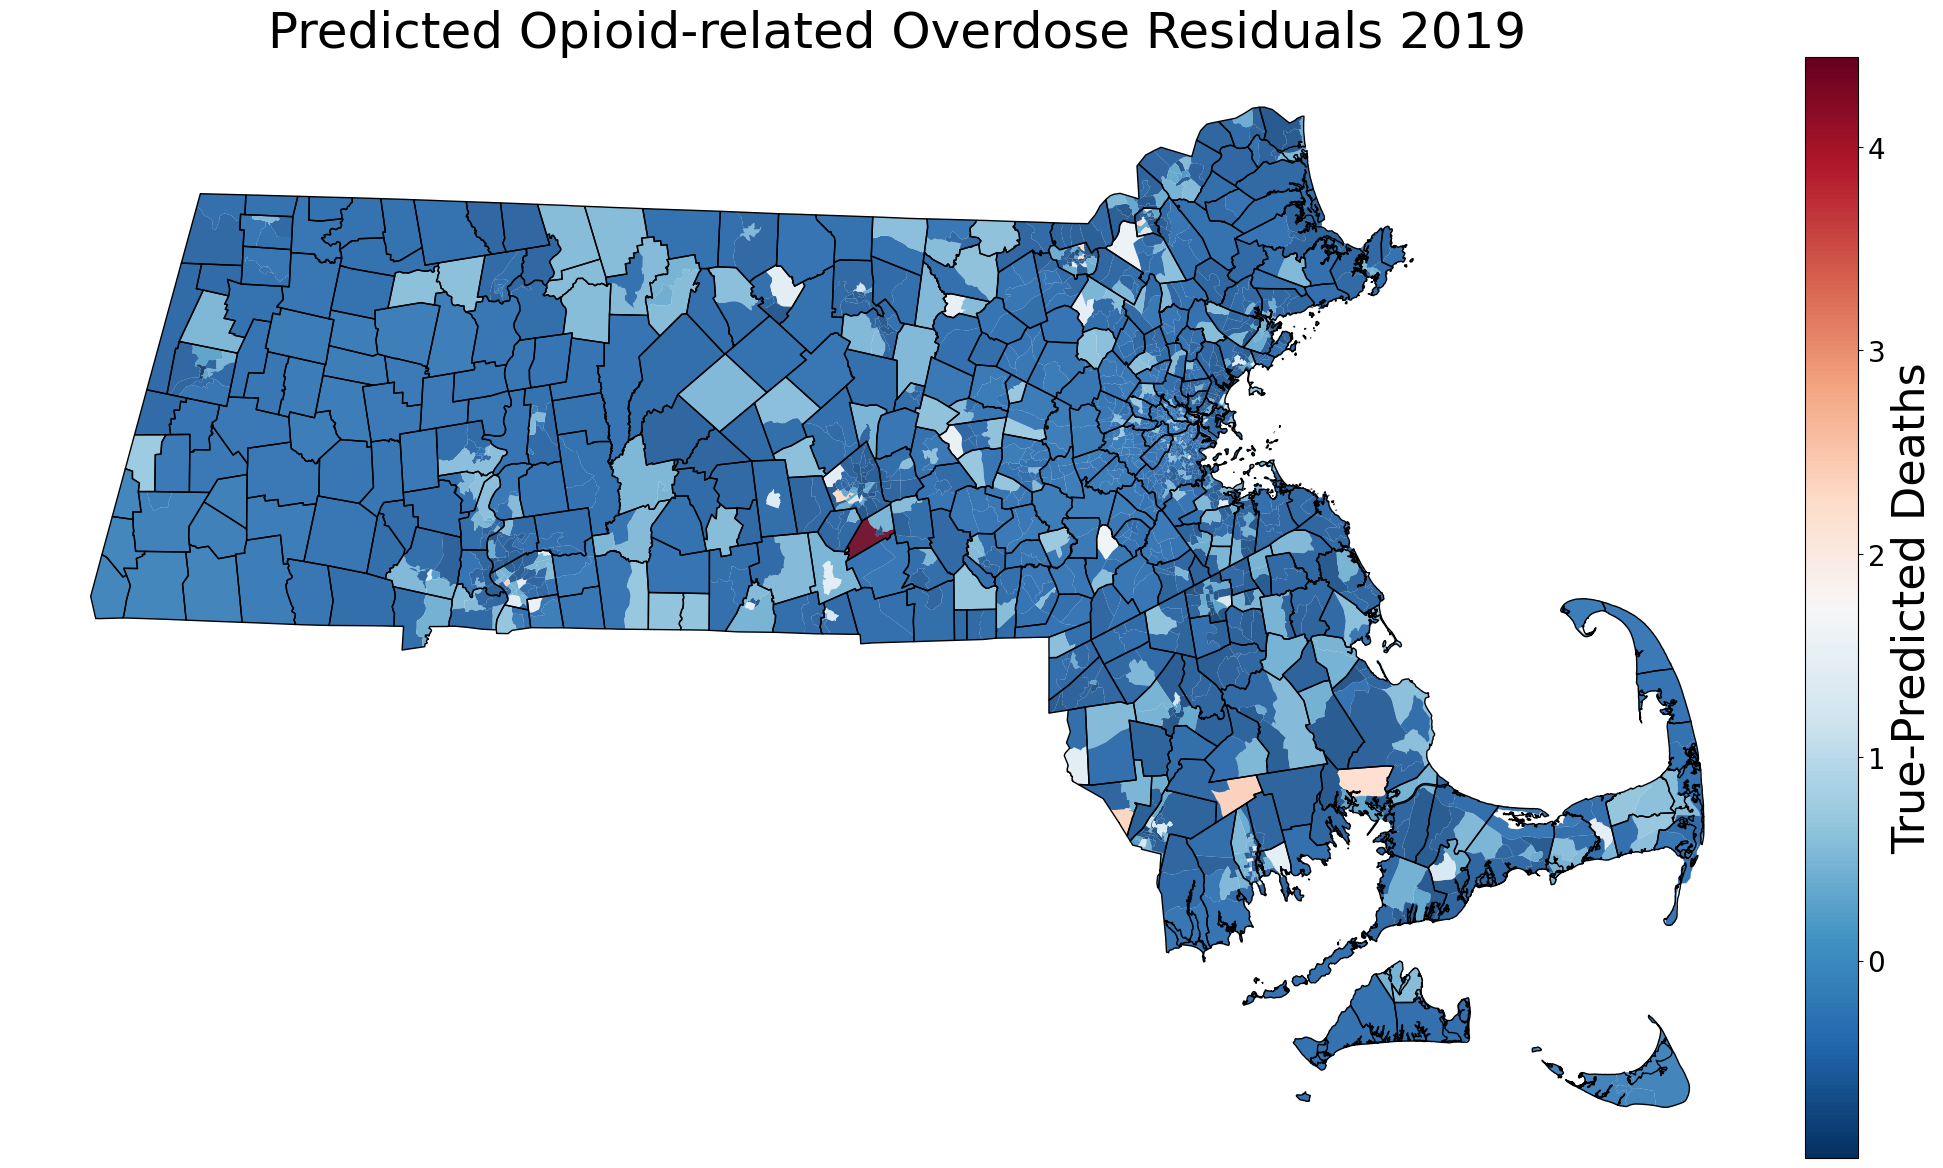

In [102]:
data='residuals'
cmap='RdBu_r'
zoom=11
dpi=100

#w,s,e,n = states.total_bounds

residual_gdf.crs = "EPSG:4326"

town_gdf = town_gdf.to_crs(residual_gdf.crs)

cropped_gdf = residual_gdf
f,ax = plt.subplots(1,1, figsize=(20,12), sharex=True, sharey=True, dpi=dpi)
f.tight_layout(pad=0.8)
ax.set_axis_off()
minx, miny, maxx, maxy = cropped_gdf.to_crs(epsg=4326).total_bounds
#ax.set_xlim(minx, maxx-(maxx-minx)*0.4)
#ax.set_ylim(miny, maxy)
plt.title('Predicted Opioid-related Overdose Residuals 2019',fontsize=36)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = residual_gdf.to_crs(epsg=3857).plot(data, ax=ax, edgecolor=None, cmap=cmap,
                                         alpha = 0.9, legend=True, cax=cax)
u2x = town_gdf.to_crs(epsg=3857).plot(ax=ux, edgecolor='k',facecolor='none', cmap=cmap,   alpha = 1, legend=True, cax=cax)
cax.tick_params(labelsize=20)
#ctx.add_basemap(ux, zoom=zoom,reset_extent=True,source=ctx.providers.Esri.WorldTerrain);

plt.ylabel('True-Predicted Deaths', fontsize=32)
# Use savefig to save your map
plt.savefig('State2019_Residuals.png',bbox_inches='tight')
plt.show()

<AxesSubplot: >

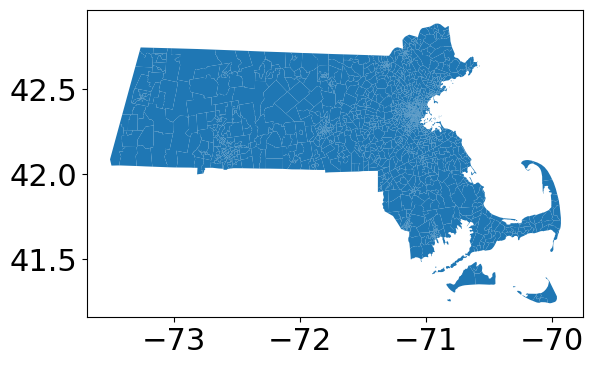

In [86]:
residual_gdf.plot()

In [11]:
x_time,y_time = 10,10

In [12]:
test_x_time = train_x[train_x[timestep_col] == x_time]
test_y_time = train_y[train_y[timestep_col] == y_time]
_, _, _, fmean, fvar, gmean, gvar, _, _ = predictor.build_predict(test_x_time.loc[:, features_only].values)
g_cond = tf.math.softplus(fmean * normcdf(gmean)).numpy()
pred_df = pd.Series(g_cond.squeeze(), index=test_x_time[geography_col])

In [13]:
pred_df.max()

1.5648174906677603

In [14]:
fmean.numpy().min()

-1.0002822585386104

In [15]:
fmean * normcdf(gmean).numpy().min()

<tf.Tensor: shape=(1620, 1), dtype=float64, numpy=
array([[-0.00489257],
       [ 0.00347753],
       [ 0.00028783],
       ...,
       [ 0.00979011],
       [ 0.00852256],
       [ 0.00913714]])>

In [16]:
predictor

name,class,transform,prior,trainable,shape,dtype,value
OnOffSVGP.kernf.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.18350674046336105
OnOffSVGP.kernf.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.150184030214211
OnOffSVGP.kernf.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.00708140956810208
OnOffSVGP.kernf.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.101533463731938
OnOffSVGP.kernf.kernels[2].variance,Parameter,Softplus,,True,(),float64,3.2033362938089467
OnOffSVGP.kernf.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1.4197185803628796
OnOffSVGP.kerng.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.00527941659683679
OnOffSVGP.kerng.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.4755681496620938
OnOffSVGP.kerng.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.421813034267657e-06
OnOffSVGP.kerng.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,3.7422307699376574


In [17]:
tf.math.softplus(0.0)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6931472>

In [18]:
train_x

,geoid,lat,lon,timestep,theme_1_pc,theme_2_pc,theme_3_pc,theme_4_pc,svi_pctile,neighbor_t,self_t-1
0,25001010100,42.059829,-70.200407,0.0,0.7270,0.2972,0.5268,0.6872,0.6230,0.000,0.0
1,25001010100,42.059829,-70.200407,1.0,0.7270,0.2972,0.5268,0.6872,0.6230,0.000,0.0
2,25001010100,42.059829,-70.200407,2.0,0.7270,0.2972,0.5268,0.6872,0.6230,0.000,0.0
3,25001010100,42.059829,-70.200407,3.0,0.7270,0.2972,0.5268,0.6872,0.6230,0.000,0.0
4,25001010100,42.059829,-70.200407,4.0,0.7270,0.2972,0.5268,0.6872,0.6230,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
35632,25027761402,42.531342,-71.592751,14.0,0.3794,0.3189,0.4701,0.2374,0.3199,0.125,0.0
35633,25027761402,42.531342,-71.592751,15.0,0.1522,0.2139,0.3928,0.1570,0.1229,0.000,0.0
35634,25027761402,42.531342,-71.592751,16.0,0.1522,0.2139,0.3928,0.1570,0.1229,0.000,0.0
35635,25027761402,42.531342,-71.592751,17.0,0.1522,0.2139,0.3928,0.1570,0.1229,0.125,0.0


In [19]:
test_x

,geoid,lat,lon,timestep,theme_1_pc,theme_2_pc,theme_3_pc,theme_4_pc,svi_pctile,neighbor_t,self_t-1
19,25001010100,42.059829,-70.200407,19.0,0.5846,0.3659,0.2235,0.8203,0.5854,0.000000,0.0
20,25001010100,42.059829,-70.200407,20.0,0.5846,0.3659,0.2235,0.8203,0.5854,0.000000,0.0
41,25001010206,41.922636,-70.015368,19.0,0.6196,0.5629,0.0957,0.5658,0.5244,0.000000,0.0
42,25001010206,41.922636,-70.015368,20.0,0.6196,0.5629,0.0957,0.5658,0.5244,0.000000,0.0
63,25001010208,42.013557,-70.064151,19.0,0.5517,0.2175,0.2105,0.3155,0.3246,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
35594,25027761300,42.239683,-71.701747,20.0,0.3708,0.1224,0.4081,0.0535,0.0975,0.071429,0.0
35615,25027761401,42.489753,-71.579677,19.0,0.2906,0.4124,0.3944,0.1598,0.2237,0.000000,0.0
35616,25027761401,42.489753,-71.579677,20.0,0.2906,0.4124,0.3944,0.1598,0.2237,0.000000,0.0
35637,25027761402,42.531342,-71.592751,19.0,0.2906,0.4124,0.3944,0.1598,0.2237,0.250000,0.0


In [20]:
features_only

['lat',
 'lon',
 'timestep',
 'theme_1_pc',
 'theme_2_pc',
 'theme_3_pc',
 'theme_4_pc',
 'svi_pctile',
 'neighbor_t',
 'self_t-1']

In [21]:
this_run

'annual_tract_normal_2000_-auto_400_0.05'

In [22]:
last_year = train_y[train_y[timestep_col]==18]

In [23]:
last_year_preds = last_year.set_index('geoid')['deaths']

In [24]:
last_year_preds

geoid
25001010100    0.0
25001010206    0.0
25001010208    0.0
25001010304    0.0
25001010306    0.0
              ... 
25027761100    1.0
25027761200    0.0
25027761300    0.0
25027761401    0.0
25027761402    1.0
Name: deaths, Length: 1620, dtype: float64

In [141]:
bprs = []
for t in [76,77,78,79]:
    y_2019 = test_y[test_y[timestep_col].isin([t])].groupby('geoid').sum()['deaths']
    last_2019 = all_y_qtr[all_y_qtr[timestep_col].isin([t-1])].groupby('geoid').sum()['deaths']
    bprs.append(fixed_top_X(y_2019,last_2019,100)[-1])

In [142]:
np.mean(bprs)

0.2571125508854425

In [113]:
test_y

,geoid,timestep,deaths
76,25001010100,76.0,0.0
77,25001010100,77.0,0.0
78,25001010100,78.0,1.0
79,25001010100,79.0,0.0
80,25001010100,80.0,0.0
...,...,...,...
142551,25027761402,79.0,0.0
142552,25027761402,80.0,0.0
142553,25027761402,81.0,0.0
142554,25027761402,82.0,0.0


In [114]:
last_2019

Series([], Name: deaths, dtype: float64)

In [131]:
last_year_preds

geoid
25001010100    0.0
25001010206    0.0
25001010208    0.0
25001010304    0.0
25001010306    0.0
              ... 
25027761100    1.0
25027761200    0.0
25027761300    0.0
25027761401    0.0
25027761402    1.0
Name: deaths, Length: 1620, dtype: float64

In [29]:
x_timesteps

[19.0, 19.0, 19.0, 19.0, 20.0, 20.0, 20.0, 20.0]

In [31]:
residuals.mean()

-1.8531744249895157

<AxesSubplot: >

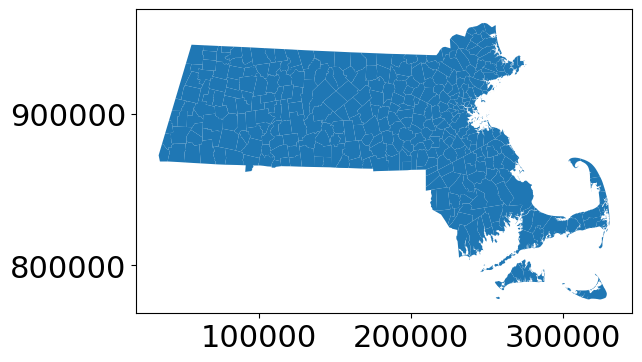